In [1]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Test dataset 전처리
#uploaded = files.upload()
test = pd.read_csv('data_ts_city.csv', header=None, skiprows=1, names=['date', 'value'])
test['date'] = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)
test_data = torch.as_tensor(test.values).to(torch.float32)

In [4]:
class NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
          
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, forecasting_size):
        self.data = data
        self.window_size = window_size
        self.forecasting_size = forecasting_size

    def __len__(self):
        return len(self.data) - self.window_size - self.forecasting_size + 1

    def __getitem__(self, idx):
        window_start = idx
        window_end = idx + self.window_size
        forecast_start = window_end
        forecast_end = window_end + self.forecasting_size

        window_data = self.data[window_start:window_end]
        forecast_data = self.data[forecast_start:forecast_end]

        return window_data, forecast_data

In [6]:
window_size = 192
forecasting_size = 24
model = NLinear(window_size, forecasting_size, False, 1)
model = torch.load('/content/drive/MyDrive/model.pt')

In [7]:
device = 'cpu'

In [8]:
criterion = nn.L1Loss()

In [9]:
# 테스트 데이터셋 생성
test_dataset = TimeSeriesDataset(test_data, window_size, forecasting_size)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 평가 모드로 전환
model.eval()

# 평가를 위한 손실 초기화
test_loss = 0.0

# 예측 결과 저장을 위한 리스트
predictions = []

# 테스트 루프
with torch.no_grad():
    for window_data, forecast_data in test_dataloader:

        # 데이터를 GPU로 이동
        window_data = window_data.to(device)
        forecast_data = forecast_data.to(device)

        # 모델 순전파
        outputs = model(window_data)

        # 손실 계산
        loss = criterion(outputs, forecast_data)

        # 손실 누적
        test_loss += loss.item()

        # 예측 결과 저장
        predictions.append(outputs.detach().cpu().numpy())

# 최종 테스트 손실 출력
print("테스트 손실:", test_loss / len(test_dataloader))   

테스트 손실: 91.31149620532932


(8209, 24) torch.Size([1, 24, 1])
테스트 손실: 91.31149620532932


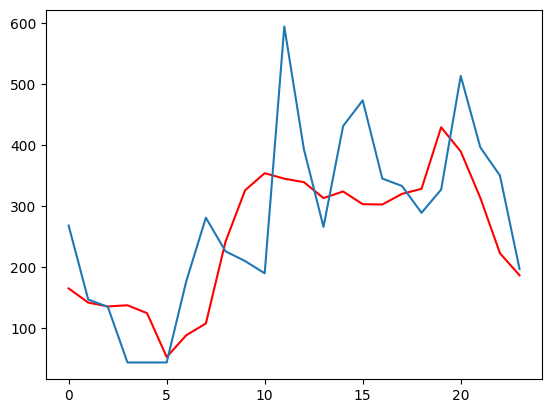

In [10]:
# Evaluate the model and get predictions
model.eval()
predictions = []
test_loss = 0.0


with torch.no_grad():
    for window_data, forecast_data in test_dataloader:
        window_data = window_data.to(device)
        forecast_data = forecast_data.to(device)

        outputs = model(window_data)
        loss = criterion(outputs, forecast_data)
        test_loss += loss.item()

        # Add the predictions to the list
        predictions.append(outputs.squeeze().detach().cpu().numpy())

if len(predictions) == 0:
    print("No predictions were made.")
else:
    # Concatenate predictions array and reshape to 2D
    test_outputs = np.array(predictions)
    # test_outputs = test_outputs.squeeze()
    forecast_data = forecast_data.cpu()
    print(test_outputs.shape, forecast_data.shape)
    print("테스트 손실:", test_loss / len(test_dataloader))
    plt.plot(predictions[0], label="Predictions", color='red')
    plt.plot(forecast_data[0], label="Actual")
    plt.show()
